In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [183]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

4992206
Title: Abu Dhabi Ports and Microsoft collaborate to provide innovative technology solutions - Al Khaleej
Description: Abu Dhabi Ports announced the signing of a new partnership agreement with Microsoft, opening the door to a new era of adopting digital solutions at Khalifa Port, affiliated with Abu Dhabi Ports, in the presence of His Excellency Omar bin Sultan Al Olama, Minister of State for Artificial Intelligence in the United Arab Emirates.
Original Language: Arabic


In [184]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Abu Dhabi Ports and Microsoft collaborate to provide innovative technology solutions - Al Khaleej
Description: Abu Dhabi Ports announced the signing of a new partnership agreement with Microsoft, opening the door to a new era of adopting digital solutions at Khalifa Port, affiliated with Abu Dhabi Ports, in the presence of His Excellency Omar bin Sultan Al Olama, Minister of State for Artificial Intelligence in the United Arab Emirates.
Original Language: Arabic
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about th

In [185]:
##############################################
motivation_raw = '''
{
  "title": "Digital Transformation at Khalifa Port: Data-Driven Insights",
  "introduction": "Following the recent partnership between Abu Dhabi Ports and Microsoft, it's fascinating to think about how Khalifa Port's operations might change. By examining data on cargo volumes, ship arrival times, and turnaround efficiencies before and after the introduction of Microsoft's technology, we could really see the impact of these digital solutions. It would be a great way to understand the benefits of this collaboration, especially in terms of operational efficiency and time management at the port."
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [186]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [187]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Operational Efficiency Improvement",
    "description": "Improvement in operational efficiency at Khalifa Port post technology implementation",
    "type": "outcome",
    "observed": true,
    "values": ["No Improvement", "Improvement"],
    "parents": ["Technology Implementation", "Training & Development", "Process Optimization"]
  },
  {
    "name": "Technology Implementation",
    "description": "Implementation of Microsoft's innovative technology solutions at Khalifa Port",
    "type": "treatment",
    "observed": true,
    "values": ["Not Implemented", "Implemented"],
    "parents": ["Market Demand"]
  },
  {
    "name": "Training & Development",
    "description": "Training and development programs for Khalifa Port employees to use new technologies",
    "type": "treatment",
    "observed": true,
    "values": ["Not Conducted", "Conducted"],
    "parents": ["Management Quality"]
  },
  {
    "name": "Market Demand",
    "description": "The demand for cargo handling and other services at Khalifa Port",
    "type": "confounder",
    "observed": true,
    "values": ["Low Demand", "High Demand"],
    "parents": []
  },
  {
    "name": "Management Quality",
    "description": "Overall quality and effectiveness of the management at Khalifa Port",
    "type": "confounder",
    "observed": true,
    "values": ["Poor Quality", "High Quality"],
    "parents": []
  },
  {
    "name": "Process Optimization",
    "description": "The level of optimization in port processes due to technology and employee engagement",
    "type": "mediator",
    "observed": false,
    "values": ["Not Optimized", "Optimized"],
    "parents": ["Technology Implementation", "Employee Engagement"]
  },
  {
    "name": "Employee Engagement",
    "description": "Engagement and adaptation of port employees to new technology and processes",
    "type": "mediator",
    "observed": false,
    "values": ["Low Engagement", "High Engagement"],
    "parents": ["Training & Development", "Management Quality"]
  },
  {
    "name": "Public Perception",
    "description": "The public perception of Khalifa Port's performance and technological advancements",
    "type": "collider",
    "observed": true,
    "values": ["Negative Perception", "Positive Perception"],
    "parents": ["Operational Efficiency Improvement", "Market Demand"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

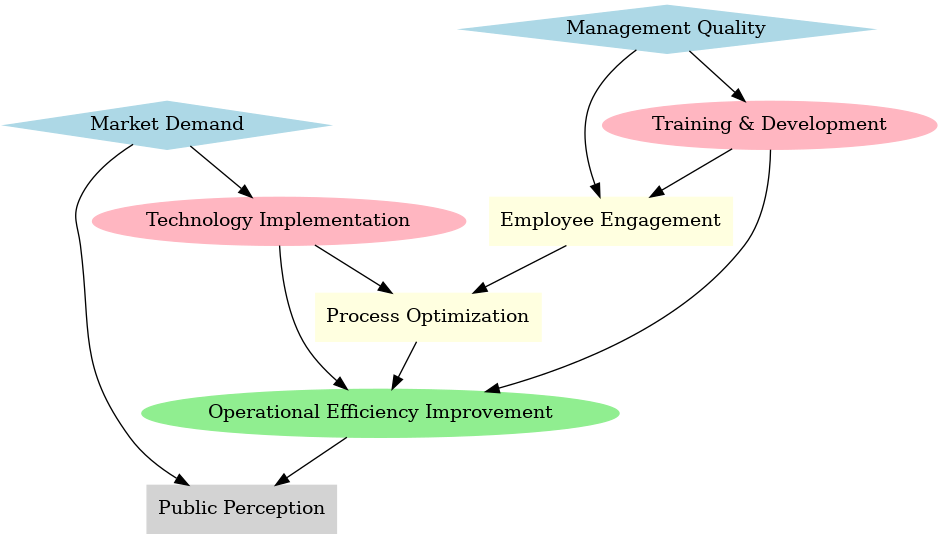

In [188]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [189]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

Following the recent partnership between Abu Dhabi Ports and Microsoft, it's fascinating to think about how Khalifa Port's operations might change. By examining data on cargo volumes, ship arrival times, and turnaround efficiencies before and after the introduction of Microsoft's technology, we could really see the impact of these digital solutions. It would be a great way to understand the benefits of this collaboration, especially in terms of operational efficiency and time management at the port.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and thei

In [190]:
#################################################

structure_raw = '''
[
	{
		"sentence": "It's intriguing how the demand for cargo handling and other services at Khalifa Port influences the implementation of new technology solutions, suggesting that market needs drive technological upgrades.",
		"involved": ["Market Demand", "Technology Implementation"]
	},
	{
		"sentence": "The overall quality of management at the port not only shapes the training and development programs for employees but also directly impacts how engaged these employees are with new technologies and processes.",
		"involved": ["Management Quality", "Training & Development", "Employee Engagement"]
	},
	{
		"sentence": "The introduction of innovative technology and the level of employee engagement work together to optimize port processes, reflecting a dynamic interplay between technology use and workforce adaptation.",
		"involved": ["Technology Implementation", "Employee Engagement", "Process Optimization"]
	},
	{
		"sentence": "Improvements in operational efficiency at the port result from the combined effects of new technology, employee training, and process optimization, highlighting a multifaceted approach to enhancing port operations.",
		"involved": ["Technology Implementation", "Training & Development", "Process Optimization", "Operational Efficiency Improvement"]
	},
	{
		"sentence": "Interestingly, the public's perception of the port's performance is shaped both by the actual improvements in operational efficiency and the demand for port services, indicating a complex relationship between public opinion, service quality, and market demand.",
		"involved": ["Operational Efficiency Improvement", "Market Demand", "Public Perception"]
	}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [191]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

Following the recent partnership between Abu Dhabi Ports and Microsoft, it's fascinating to think about how Khalifa Port's operations might change. By examining data on cargo volumes, ship arrival times, and turnaround efficiencies before and after the introduction of Microsoft's technology, we could really see the impact of these digital solutions. It would be a great way to understand the benefits of this collaboration, especially in terms of operational efficiency and time management at the port.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Market Demand" is "High Demand" (rather than "Low Demand")?
2. when "Market Demand" is "Low Demand": what is the probability that "Technology Implementation" is "Implemented" (rather than "Not Implemented")?
3. when "Market Dem

In [192]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.6, 0.7],
  "2": [0.2, 0.3],
  "3": [0.8, 0.9],
  "4": [0.5, 0.6],
  "5": [0.3, 0.4],
  "6": [0.7, 0.8],
  "7": [0.1, 0.2],
  "8": [0.4, 0.5],
  "9": [0.4, 0.5],
  "10": [0.8, 0.9],
  "11": [0.1, 0.2],
  "12": [0.3, 0.4],
  "13": [0.5, 0.6],
  "14": [0.7, 0.8],
  "15": [0.1, 0.2],
  "16": [0.3, 0.4],
  "17": [0.2, 0.3],
  "18": [0.4, 0.5],
  "19": [0.4, 0.5],
  "20": [0.6, 0.7],
  "21": [0.5, 0.6],
  "22": [0.8, 0.9],
  "23": [0.2, 0.3],
  "24": [0.3, 0.4],
  "25": [0.6, 0.7],
  "26": [0.7, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [193]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------------------  ---------------  -----------  ------------------------------------------------------------------------------------
Technology Implementation           Not Implemented  Implemented  Implementation of Microsoft's innovative technology solutions at Khalifa Port
Training & Development              Not Conducted    Conducted    Training and development programs for Khalifa Port employees to use new technologies
Operational Efficiency Improvement  No Improvement   Improvement  Improvement in operational efficiency at Khalifa Port post technology implementation
----------------------------------  ---------------  -----------  ------------------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Market Demand' means The demand for cargo handling and other services at Khalifa Port
'Technology Implementation' means Implementation of Microsoft's innovative technology solutions at Khalifa Port
'Management Quality' means Overall quality and effectiveness of the management at Khalifa Port
'Training & Development' means Training and development programs for Khalifa Port employees to use new technologies
'Employee Engagement' means Engagement and adaptation of port employees to new technology and processes
'Process Optimization' means The level of optimization in port processes due to technology and employee engagement
'Operational Efficiency Improvement' means Improvement in operational efficiency at Khalifa Port post technology implementation
'Public Perception' means The public perception of Khalifa Port's performance and technological advancements
Treatment Value    Treatment                  Outcome Value    Outcome                                  ATE    Correlation
-----------

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                         ATE    Correlation  Outcome
----------------------------------------------  -----  -------------  ----------------------------------------------
High Demand Market Demand                        0.63           0.62  Implemented Technology Implementation
High Demand Market Demand                        0              0     High Quality Management Quality
High Demand Market Demand                        0              0     Conducted Training & Development
High Demand Market Demand                        0             -0     High Engagement Employee Engagement
High Demand Market Demand                        0.25           0.23  Optimized Process Optimization
High Demand Market Demand                        0.25           0.22  Improvement Operational Efficiency Improvement
High Demand Market Demand                        0.17           0.15  Positive Perception Public Perception
Implemented Technology Implementation            0          

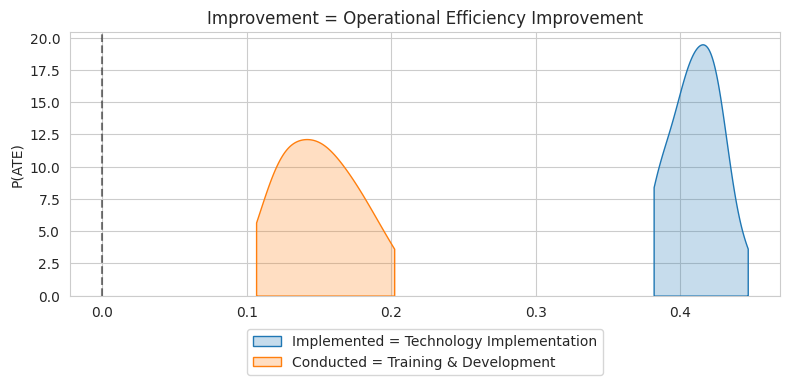

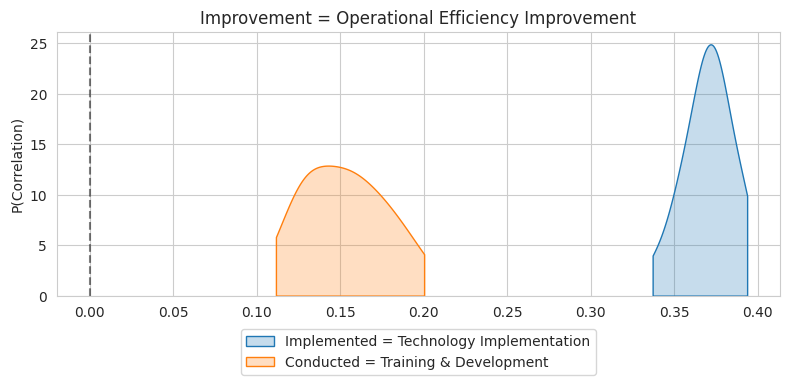

In [194]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [195]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Market Demand' (0='Low Demand', 1='High Demand') means The demand for cargo handling and other services at Khalifa Port
Variable 'Technology Implementation' (0='Not Implemented', 1='Implemented') means Implementation of Microsoft's in

In [196]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Market Demand": {
    "descriptor": ["the market demand at Khalifa Port", "the level of demand for Khalifa Port's services"],
    "subject": "Khalifa Port",
    "predicate0": ["experiences lower demand for its services", "is not as busy with cargo handling"],
    "predicate1": ["sees a high demand for its services", "is bustling with cargo handling activities"],
    "pronoun": "it",
    "nounclause0": ["Khalifa Port is experiencing a quieter period", "there is a lull in Khalifa Port's activities"],
    "nounclause1": ["Khalifa Port is going through a busy period", "there is a surge in Khalifa Port's activities"],
    "preposition": ["During", "In"],
    "domain": "times",
    "subclause0": ["the port isn't as crowded", "cargo handling slows down"],
    "subclause1": ["the port is filled with activity", "cargo handling is at its peak"],
    "condition0": ["When Khalifa Port faces lower demand", "During periods of low activity at the port"],
    "condition1": ["When Khalifa Port faces high demand", "During peak times at the port"],
    "action0": ["demand decreases at Khalifa Port", "the port experiences a drop in activity"],
    "action1": ["demand increases at Khalifa Port", "the port sees a surge in cargo handling"]
  },
  "Technology Implementation": {
    "descriptor": ["the implementation of new technology at Khalifa Port", "the adoption of Microsoft's solutions at Khalifa Port"],
    "subject": "Khalifa Port",
    "predicate0": ["has not adopted new technological solutions", "is yet to implement Microsoft's technology"],
    "predicate1": ["has embraced new technological solutions", "is utilizing Microsoft's innovative technology"],
    "pronoun": "it",
    "nounclause0": ["Khalifa Port is still operating with its old systems", "there's no new tech at Khalifa Port yet"],
    "nounclause1": ["Khalifa Port has upgraded to new systems", "new technology is in use at Khalifa Port"],
    "preposition": ["With", "In"],
    "domain": "cases",
    "subclause0": ["the port sticks to its old methods", "there is no sign of technological advancement"],
    "subclause1": ["the port moves forward with modern solutions", "you can see the technological advancement"],
    "condition0": ["If Khalifa Port doesn't adopt new technology", "Without technological upgrades at the port"],
    "condition1": ["If Khalifa Port adopts new technology", "With the introduction of new technology at the port"],
    "action0": ["Khalifa Port rejects the adoption of new technology", "the port decides against modernizing its systems"],
    "action1": ["Khalifa Port decides to implement new technology", "the port chooses to modernize its systems"]
  },
  "Management Quality": {
    "descriptor": ["the management quality at Khalifa Port", "the effectiveness of Khalifa Port's management"],
    "subject": "The management team at Khalifa Port",
    "predicate0": ["is not performing up to the mark", "is struggling with effectiveness"],
    "predicate1": ["is excelling in their roles", "demonstrates high effectiveness"],
    "pronoun": "they",
    "nounclause0": ["the management at Khalifa Port is underperforming", "there are challenges in management effectiveness"],
    "nounclause1": ["the management at Khalifa Port is outstanding", "there's a high level of efficiency in management"],
    "preposition": ["Under", "With"],
    "domain": "conditions",
    "subclause0": ["the management faces difficulties", "the port's leadership is faltering"],
    "subclause1": ["the management shines in its role", "the port's leadership excels"],
    "condition0": ["When management quality is low", "If the management at the port is not effective"],
    "condition1": ["When management quality is high", "If the port's management is effective"],
    "action0": ["the management's quality dips", "the port's leadership faces setbacks"],
    "action1": ["the management improves its quality", "the port's leadership takes effective measures"]
  },
  "Training & Development": {
    "descriptor": ["training and development initiatives at Khalifa Port", "employee training programs at the port"],
    "subject": "Khalifa Port",
    "predicate0": ["hasn't conducted any training programs", "is lacking in employee development"],
    "predicate1": ["is actively conducting training and development", "focuses on employee skill enhancement"],
    "pronoun": "it",
    "nounclause0": ["no new training initiatives are underway at Khalifa Port", "employees are not receiving additional training"],
    "nounclause1": ["new training programs are in full swing at Khalifa Port", "employees are being upskilled"],
    "preposition": ["In", "Across"],
    "domain": "phases",
    "subclause0": ["employees stick to their usual routines", "there's a lack of learning opportunities"],
    "subclause1": ["employees are learning new skills", "there's an environment of growth and learning"],
    "condition0": ["If training is not provided at Khalifa Port", "Without employee development programs"],
    "condition1": ["If training programs are conducted", "With an emphasis on employee development"],
    "action0": ["training programs are not initiated", "the port neglects employee skill building"],
    "action1": ["Khalifa Port starts a training initiative", "the port invests in employee development"]
  },
  "Employee Engagement": {
    "descriptor": ["employee engagement with new technology at Khalifa Port", "how port employees adapt to new processes"],
    "subject": "Employees at Khalifa Port",
    "predicate0": ["are not very engaged with new technology", "show little interest in new processes"],
    "predicate1": ["are highly engaged with new technology", "actively adapt to new processes"],
    "pronoun": "they",
    "nounclause0": ["there's a noticeable lack of enthusiasm among the employees for new technology", "employees are slow to adapt to changes"],
    "nounclause1": ["employees are embracing technological changes enthusiastically", "there's a quick adaptation to new processes among employees"],
    "preposition": ["Despite", "With"],
    "domain": "scenarios",
    "subclause0": ["employees remain indifferent to new systems", "there's a reluctance to change"],
    "subclause1": ["employees are eager to work with new systems", "there's an eagerness for change"],
    "condition0": ["Even if new technology is introduced", "Despite the availability of new processes"],
    "condition1": ["When new technology is implemented", "With the introduction of new processes"],
    "action0": ["employees resist engaging with new tech", "the workforce is hesitant to embrace change"],
    "action1": ["employees are encouraged to engage with new tech", "the workforce is trained for new processes"]
  },
  "Process Optimization": {
    "descriptor": ["process optimization at Khalifa Port", "the efficiency of port operations"],
    "subject": "Operations at Khalifa Port",
    "predicate0": ["have not been optimized", "lack efficiency improvements"],
    "predicate1": ["are highly optimized", "exhibit significant efficiency improvements"],
    "pronoun": "they",
    "nounclause0": ["the port's operations continue as usual without any major changes", "there's no noticeable improvement in operational efficiency"],
    "nounclause1": ["operations at the port are streamlined and efficient", "a marked improvement in efficiency is evident"],
    "preposition": ["Despite", "With"],
    "domain": "times",
    "subclause0": ["the processes remain unchanged", "there's little to no enhancement in procedures"],
    "subclause1": ["the processes are fine-tuned", "innovative practices are implemented"],
    "condition0": ["Even with new technology", "Despite efforts for change"],
    "condition1": ["When new systems are in place", "With effective use of technology"],
    "action0": ["processes are not refined", "efficiency is not a priority"],
    "action1": ["a focus on optimizing processes begins", "efforts to improve efficiency are made"]
  },
  "Public Perception": {
    "descriptor": ["the public's view of Khalifa Port", "community sentiment towards Khalifa Port's advancements", "public opinion of Khalifa Port's performance"],
    "subject": "public opinion",
    "predicate0": ["is critical of Khalifa Port", "leans negatively towards Khalifa Port's advancements"],
    "predicate1": ["is favorable towards Khalifa Port", "supports Khalifa Port's technological progress"],
    "pronoun": "it",
    "nounclause0": ["the public views Khalifa Port negatively", "there is a critical perception of Khalifa Port's advancements"],
    "nounclause1": ["the public views Khalifa Port positively", "there is widespread approval of Khalifa Port's technological advancements"],
    "preposition": ["among", "in"],
    "domain": "community opinions",
    "subclause0": ["the sentiment is critical towards Khalifa Port", "negative views are held about Khalifa Port's performance"],
    "subclause1": ["the sentiment is supportive of Khalifa Port", "positive views prevail about Khalifa Port's technological strides"],
    "condition0": ["if the public perception is negative", "when Khalifa Port is viewed critically"],
    "condition1": ["if the public perception is positive", "when Khalifa Port is viewed favorably"],
    "action0": ["the public sentiment shifts negatively", "there is a turn towards negative perception of Khalifa Port"],
    "action1": ["the public sentiment becomes positive", "there is a shift towards favorable views of Khalifa Port"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [197]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

Following the recent partnership between Abu Dhabi Ports and Microsoft, it's fascinating to think about how Khalifa Port's operations might change. By examining data on cargo volumes, ship arrival times, and turnaround efficiencies before and after the introduction of Microsoft's technology, we could really see the impact of these digital solutions. It would be a great way to understand the benefits of this collaboration, especially in terms of operational efficiency and time management at the port.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Technology Implementation') > 0
	2. ATE('Training & Development') > 0
	3. ATE('Technology Implementation') < ATE('Training & Development')
	4. |ATE('Technology Implementation')| < |ATE('Training & Developme

In [198]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {
        "question": "Does implementing Microsoft's technology at Khalifa Port improve operational efficiency?",
        "answer": "yes",
        "claim": "Implementing Microsoft's technology at Khalifa Port leads to improved operational efficiency."
    },
    "2": {
        "question": "Does conducting training and development programs for Khalifa Port employees enhance operational efficiency?",
        "answer": "yes",
        "claim": "Conducting training and development programs for Khalifa Port employees enhances operational efficiency."
    },
    "3": {
        "question": "Is the impact of training and development on operational efficiency greater than that of implementing technology at Khalifa Port?",
        "answer": "yes",
        "claim": "The impact of training and development on operational efficiency is greater than that of implementing technology at Khalifa Port."
    },
    "4": {
        "question": "Is the impact of training and development on operational efficiency more significant than that of implementing technology at Khalifa Port?",
        "answer": "yes",
        "claim": "The impact of training and development on operational efficiency is more significant than that of implementing technology at Khalifa Port."
    },
    "5": {
        "question": "Does implementing technology at Khalifa Port improve operational efficiency when market demand is low?",
        "answer": "yes",
        "claim": "When market demand is low, implementing technology at Khalifa Port improves operational efficiency."
    },
    "6": {
        "question": "Does conducting training and development programs improve operational efficiency at Khalifa Port when market demand is low?",
        "answer": "yes",
        "claim": "Conducting training and development programs improves operational efficiency at Khalifa Port when market demand is low."
    },
    "7": {
        "question": "Is the impact of implementing technology on operational efficiency greater than training and development when market demand is low at Khalifa Port?",
        "answer": "yes",
        "claim": "When market demand is low, the impact of implementing technology on operational efficiency at Khalifa Port is greater than training and development."
    },
    "8": {
        "question": "Is the positive impact of implementing technology on operational efficiency more significant than training and development when market demand is low at Khalifa Port?",
        "answer": "yes",
        "claim": "When market demand is low at Khalifa Port, the positive impact of implementing technology on operational efficiency is more significant than training and development."
    },
    "9": {
        "question": "Does implementing technology at Khalifa Port improve operational efficiency when market demand is high?",
        "answer": "yes",
        "claim": "When market demand is high, implementing technology at Khalifa Port improves operational efficiency."
    },
    "10": {
        "question": "Does conducting training and development programs reduce operational efficiency at Khalifa Port when market demand is high?",
        "answer": "no",
        "claim": "Conducting training and development programs does not reduce operational efficiency at Khalifa Port when market demand is high."
    },
    "11": {
        "question": "Is the impact of implementing technology on operational efficiency greater than training and development when market demand is high at Khalifa Port?",
        "answer": "yes",
        "claim": "When market demand is high, the impact of implementing technology on operational efficiency at Khalifa Port is greater than training and development."
    },
    "12": {
        "question": "Is the positive impact of training and development on operational efficiency more significant than implementing technology when market demand is high at Khalifa Port?",
        "answer": "no",
        "claim": "When market demand is high at Khalifa Port, the positive impact of training and development on operational efficiency is not more significant than implementing technology."
    },
    "13": {
        "question": "Is the improvement in operational efficiency greater when implementing technology at Khalifa Port under high market demand compared to low market demand?",
        "answer": "no",
        "claim": "The improvement in operational efficiency when implementing technology at Khalifa Port is not greater under high market demand compared to low market demand."
    },
    "14": {
        "question": "Is the positive impact of implementing technology on operational efficiency more significant under low market demand than high market demand at Khalifa Port?",
        "answer": "no",
        "claim": "The positive impact of implementing technology on operational efficiency at Khalifa Port is not more significant under low market demand than under high market demand."
    },
    "15": {
        "question": "Is the improvement in operational efficiency greater when conducting training and development at Khalifa Port under high market demand compared to low market demand?",
        "answer": "yes",
        "claim": "The improvement in operational efficiency when conducting training and development at Khalifa Port is greater under high market demand compared to low market demand."
    },
    "16": {
        "question": "Is the positive impact of conducting training and development on operational efficiency more significant under high market demand than low market demand at Khalifa Port?",
        "answer": "no",
        "claim": "The positive impact of conducting training and development on operational efficiency at Khalifa Port is not more significant under high market demand than under low market demand."
    },
    "17": {
        "question": "Does implementing technology reduce operational efficiency at Khalifa Port when management quality is poor?",
        "answer": "yes",
        "claim": "When management quality is poor at Khalifa Port, implementing technology reduces operational efficiency."
    },
    "18": {
        "question": "Does conducting training and development programs reduce operational efficiency at Khalifa Port when management quality is poor?",
        "answer": "yes",
        "claim": "When management quality is poor at Khalifa Port, conducting training and development programs reduces operational efficiency."
    },
    "19": {
        "question": "Is the negative impact of implementing technology on operational efficiency less than training and development when management quality is poor at Khalifa Port?",
        "answer": "yes",
        "claim": "When management quality is poor at Khalifa Port, the negative impact of implementing technology on operational efficiency is less than that of training and development."
    },
    "20": {
        "question": "Is the negative impact of training and development on operational efficiency more significant than implementing technology when management quality is poor at Khalifa Port?",
        "answer": "yes",
        "claim": "When management quality is poor at Khalifa Port, the negative impact of training and development on operational efficiency is more significant than that of implementing technology."
    },
    "21": {
        "question": "Does implementing technology reduce operational efficiency at Khalifa Port when management quality is high?",
        "answer": "no",
        "claim": "When management quality is high at Khalifa Port, implementing technology does not reduce operational efficiency."
    },
    "22": {
        "question": "Does conducting training and development programs reduce operational efficiency at Khalifa Port when management quality is high?",
        "answer": "no",
        "claim": "When management quality is high at Khalifa Port, conducting training and development programs does not reduce operational efficiency."
    },
    "23": {
        "question": "Is the negative impact of implementing technology on operational efficiency less than training and development when management quality is high at Khalifa Port?",
        "answer": "no",
        "claim": "When management quality is high at Khalifa Port, the negative impact of implementing technology on operational efficiency is not less than that of training and development."
    },
    "24": {
        "question": "Is the negative impact of training and development on operational efficiency less significant than implementing technology when management quality is high at Khalifa Port?",
        "answer": "yes",
        "claim": "When management quality is high at Khalifa Port, the negative impact of training and development on operational efficiency is less significant than that of implementing technology."
    },
    "25": {
        "question": "Is the improvement in operational efficiency greater when implementing technology at Khalifa Port under high management quality compared to poor management quality?",
        "answer": "yes",
        "claim": "The improvement in operational efficiency when implementing technology at Khalifa Port is greater under high management quality compared to poor management quality."
    },
    "26": {
        "question": "Is the positive impact of implementing technology on operational efficiency more significant under poor management quality than high management quality at Khalifa Port?",
        "answer": "no",
        "claim": "The positive impact of implementing technology on operational efficiency at Khalifa Port is not more significant under poor management quality than under high management quality."
    },
    "27": {
        "question": "Is the improvement in operational efficiency greater when conducting training and development at Khalifa Port under high management quality compared to poor management quality?",
        "answer": "no",
        "claim": "The improvement in operational efficiency when conducting training and development at Khalifa Port is not greater under high management quality compared to poor management quality."
    },
    "28": {
        "question": "Is the positive impact of conducting training and development on operational efficiency more significant under high management quality than poor management quality at Khalifa Port?",
        "answer": "yes",
        "claim": "The positive impact of conducting training and development on operational efficiency at Khalifa Port is more significant under high management quality than under poor management quality."
    }
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [199]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Digital Transformation at Khalifa Port: Data-Driven Insights.json'